# Network continuity with OS Open Roads data

## Data Source

The following example uses the [OS Open Roads](https://osdatahub.os.uk/downloads/open/OpenRoads) dataset, which is available under the [Open Government License](http://os.uk/opendata/licence).

_© Crown copyright and database right 2022_

## Preparation

The following example assumes:
- That the notebook is being run from a cloned `cityseer-api` repository.
- That the above dataset has been downloaded to `temp/os_open_roads/oproad_gb.gpkg` as a relative path. If running this notebook directly from within a clone of the `cityseer-api` repo, then this equates to the `cityseer-api/temp/os_open_roads/oproad_gb.gpkg` path. Please edit the paths and path setup in this cell if you are using different directories.


In [11]:
from __future__ import annotations

from pathlib import Path

repo_path = Path.cwd()
if str(repo_path).endswith("connectivity"):
    repo_path = Path.cwd() / "../.."
if not str(repo_path.resolve()).endswith("cityseer-api"):
    raise ValueError("Please check your notebook working directory relative to your project and data paths.")

open_roads_path = Path(repo_path / "temp/os_open_roads/oproad_gb.gpkg")
print("data path:", open_roads_path)
print("path exists:", open_roads_path.exists())

data path: /Users/gareth/dev/benchmark-urbanism/cityseer-api/demos/connectivity/../../temp/os_open_roads/oproad_gb.gpkg
path exists: True


### Extents

Instead of loading the entire dataset, we'll use a bounding box to only load an area of interest.

In [12]:
from pyproj import Transformer
from shapely import geometry

from cityseer.tools import io

# create graph - only UK locations will work for OS Open Roads data
# stratford-upon-avon
# lng, lat, buffer_dist, plot_buffer = -1.7063649924889566, 52.19277374082795, 1500, 1250
# london
lng, lat, buffer_dist, plot_buffer = -0.13039709427587876, 51.516434828344366, 6000, 5000
# transform from WGS to BNG
transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700")
easting, northing = transformer.transform(lat, lng)
# calculate bbox relative to centroid
centroid = geometry.Point(easting, northing)
target_bbox: tuple[float, float, float, float] = centroid.buffer(buffer_dist).bounds  # type: ignore
plot_bbox: tuple[float, float, float, float] = centroid.buffer(plot_buffer).bounds  # type: ignore

### Load

We can now load the OS Open Roads dataset

In [13]:
# load OS Open Roads data from downloaded geopackage
G_open = io.nx_from_open_roads(open_roads_path, target_bbox=target_bbox)

INFO:cityseer.tools.io:Nodes: 24736
INFO:cityseer.tools.io:Edges: 32685
INFO:cityseer.tools.io:Dropped 461 edges where not both start and end nodes were present.
INFO:cityseer.tools.io:Running basic graph cleaning
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 30659/30659 [00:00<00:00, 130888.83it/s]


## Observe continuity metrics

This step runs the continuity analysis using the specified heuristic.

In [25]:
import matplotlib.pyplot as plt

from cityseer.tools import io, plot
from cityseer.metrics import observe

import importlib

importlib.reload(observe)

# methods can be "names", "refs", "highways"
G_cont = observe.route_continuity(G_open, method="names")


100%|██████████| 30301/30301 [00:04<00:00, 6415.02it/s]

{'harrow road, marylebone road': [102, 102], 'finchley road, marlborough place': [94], "queen's grove, finchley road": [89], 'finchley road': [86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86], 'fulham broadway, fulham road': [86], 'porchester road, harrow road': [69], 'clapham road, stockwell road': [66], 'old kent road, peckham park road': [64], 'islington green, essex road, upper street': [63], 'harrow road': [62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62], 'sandgate street, old kent road': [62], 'windsor gardens, harrow

INFO:cityseer.tools.plot:Extracting edge geometries
100%|██████████| 30301/30301 [00:00<00:00, 802275.09it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 30301/30301 [00:02<00:00, 10197.49it/s]
INFO:cityseer.tools.plot:Extracting edge geometries
100%|██████████| 30301/30301 [00:00<00:00, 867578.71it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 30301/30301 [00:02<00:00, 10534.71it/s]


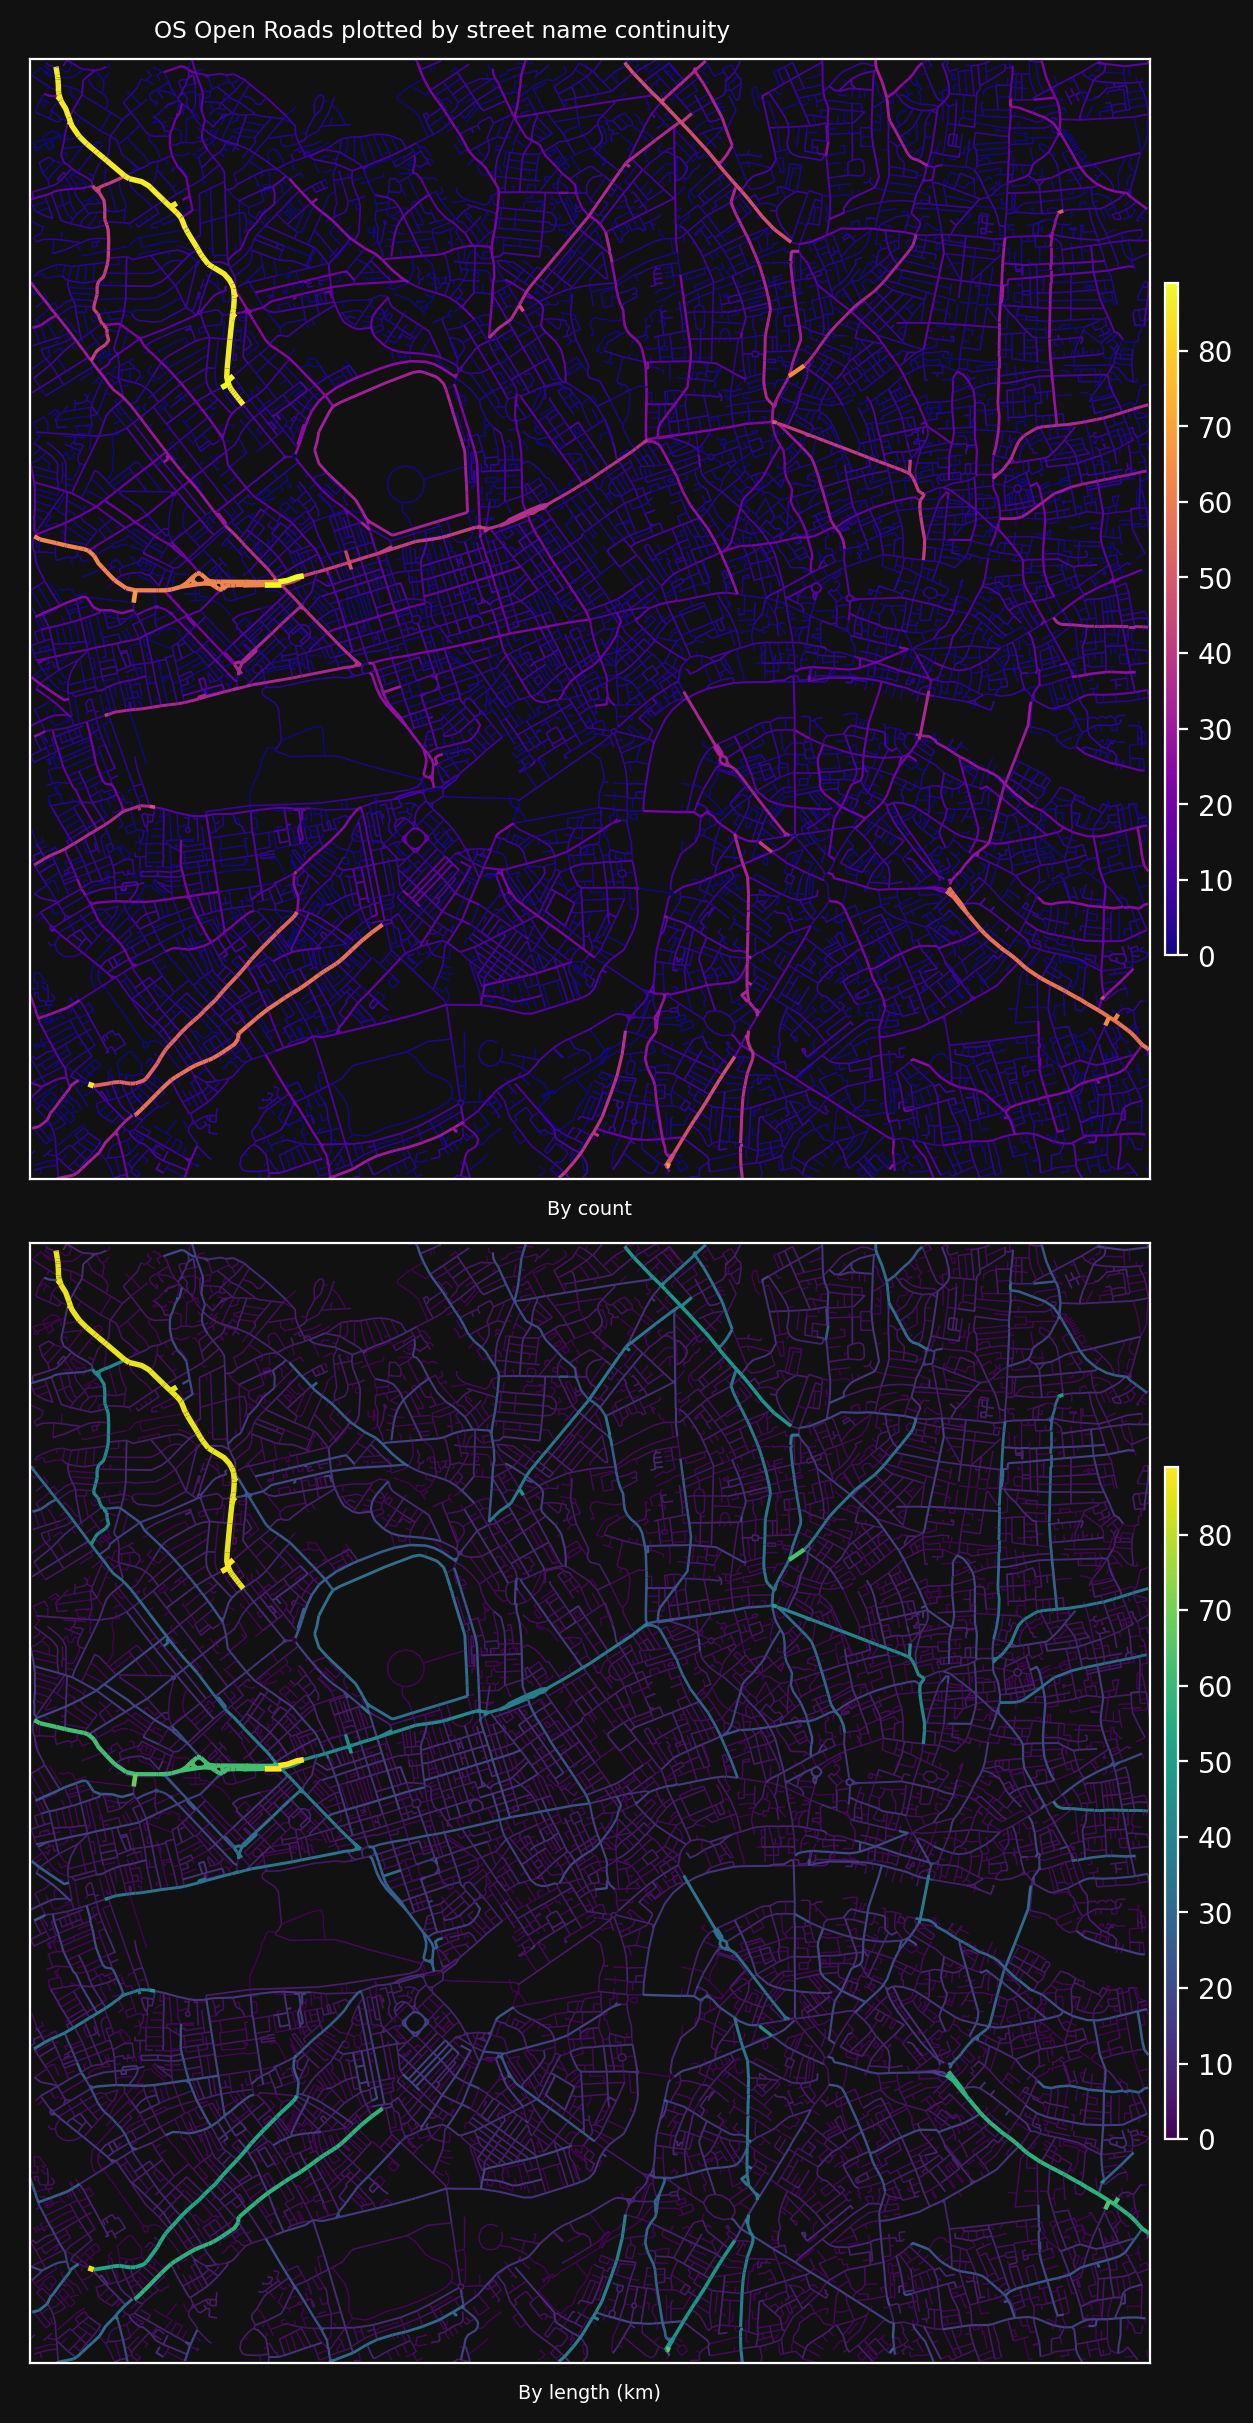

In [15]:
# plot
bg_colour = "#111"
fig, axes = plt.subplots(2, 1, dpi=200, figsize=(8, 12), facecolor=bg_colour, constrained_layout=True)
fig.suptitle("OS Open Roads plotted by street name continuity", fontsize="small", ha="center")
# by count
plot.plot_nx_edges(
    axes[0],  # type: ignore
    nx_multigraph=G_cont,
    edge_metrics_key="names_clean_agg_count",
    bbox_extents=plot_bbox,
    cmap_key="plasma",
    lw_min=0.5,
    lw_max=2,
    face_colour=bg_colour,
)
axes[0].set_xlabel("By count", fontsize="x-small")  # type: ignore
# by length
plot.plot_nx_edges(
    axes[1],  # type: ignore
    nx_multigraph=G_cont,
    edge_metrics_key="names_clean_agg_count",
    bbox_extents=plot_bbox,
    cmap_key="viridis",
    lw_min=0.5,
    lw_max=2,
    face_colour=bg_colour,
)
axes[1].set_xlabel("By length (km)", fontsize="x-small")  # type: ignore
plt.show()